In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
import pickle

from keras.models import Sequential, Model
from keras.layers import Conv2D
import os
from keras.applications.vgg16 import VGG16


In [ ]:

#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128


In [ ]:
path = glob.glob("/content/drive/MyDrive/New folder111/*.png")
path.sort()

In [ ]:
train_images = []
for img_path in path:
  img = cv2.imread(img_path, cv2.IMREAD_COLOR)
  img = cv2.resize(img, (SIZE_Y, SIZE_X))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  train_images.append(img)


In [ ]:
from google.colab.patches import cv2_imshow


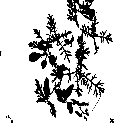

In [ ]:
cv2_imshow(train_images[0])

In [ ]:
np.shape(train_images)

(10, 128, 128, 3)

In [ ]:
#Convert list to array for machine learning processing
train_images = np.array(train_images)


In [ ]:
np.shape(train_images)

(10, 128, 128, 3)

In [ ]:
path1 = glob.glob("/content/drive/MyDrive/New folder1111/*.png")
path1.sort()
print(len(path1))

10


In [ ]:
train_masks = []

In [ ]:
for img_path1 in path1:
  mask = cv2.imread(img_path1,0)
  mask = cv2.resize(mask, (SIZE_Y, SIZE_X))
  train_masks.append(mask)
  # mask = cv2.cvtColor(mask, cv2.COLOR_RGB2BGR)
  #train_labels.append(label)

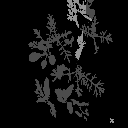

In [ ]:
cv2_imshow(train_masks[0])

In [ ]:
train_masks = np.array(train_masks)


In [ ]:
np.unique(train_masks)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  80,  82,  83,  84,  85,  87,  89,  90,  91,  92,  93,  94,
        96,  97,  98,  99, 100, 101, 102, 104, 105, 106, 108, 109, 110,
       111, 112, 113, 114, 115, 118, 119, 120, 121, 122, 123, 124, 125,
       127, 128, 129, 130, 131, 132, 133, 134, 136, 137, 138, 139, 140,
       141, 142, 143, 144, 145, 146, 147, 148, 149], dtype=uint8)

In [ ]:
np.shape(train_masks)

(10, 128, 128)

In [ ]:
#Use customary x_train and y_train variables
X_train = train_images
y_train = train_masks
y_train = np.expand_dims(y_train, axis=3) #May not be necessary.. leftover from previous code


In [ ]:
np.shape(X_train)

(10, 128, 128, 3)

In [ ]:
np.shape(y_train)

(10, 128, 128, 1)

In [ ]:

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False

VGG_model.summary()  #Trainable parameters will be 0


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
#After the first 2 convolutional layers the image dimension changes.
#So for easy comparison to Y (labels) let us only take first 2 conv layers
#and create a new model to extract features
#New model with only first 2 conv layers
new_model = Model(inputs=VGG_model.input, outputs=VGG_model.get_layer('block1_conv2').output)
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [ ]:
#Now, let us apply feature extractor to our training data
features=new_model.predict(X_train)


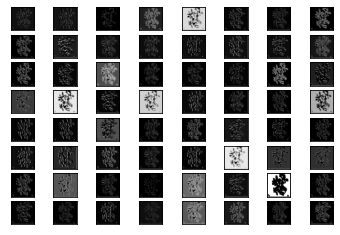

In [ ]:

#Plot features to view them
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()


In [ ]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels

#Reshape Y to match X
Y = y_train.reshape(-1)

#Combine X and Y into a dataframe to make it easy to drop all rows with Y values 0
#In our labels Y values 0 = unlabeled pixels.
dataset = pd.DataFrame(X)
dataset['Label'] = Y
print(dataset['Label'].unique())
print(dataset['Label'].value_counts())


[  0 149  76  72  23  43  96   1   9  21  77  26  24   3   7  69  80 102
  46 140 120 145  65 133  20 141 143  45 121   5  34  58  71  25  85  29
  41  52  35  93  50 127  66  68   2  37  30  89  62  70  31  14  75  73
  10   8  18  40  33  16 122  59  39  49   4  74  63   6  11  53  91  36
  92  54  13  19  55 114  84  60  42  47  64 110  51  22  56  15  61 146
  28  67  27  57  38  17  12  44 142 128 125 147  48 106 134 108 123 113
 111  83  32 138  82 105 100 129  78  98  99 139 136  97 130 104 144 112
 101 137 115 148 109 118 131 119 132  90  87  94 124]
0      147439
76      11257
149      2659
71         99
5          86
        ...  
93          1
101         1
112         1
92          1
124         1
Name: Label, Length: 139, dtype: int64


In [ ]:


##If we do not want to include pixels with value 0
##e.g. Sometimes unlabeled pixels may be given a value 0.
dataset = dataset[dataset['Label'] != 0]


In [ ]:
#Redefine X and Y for Random Forest
X_for_RF = dataset.drop(labels = ['Label'], axis=1)
Y_for_RF = dataset['Label']


In [ ]:

#RANDOM FOREST
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 50, random_state = 42,class_weight='balanced')

# Train the model on training data
model.fit(X_for_RF, Y_for_RF)


RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)

In [ ]:

#Save model for future use
filename = 'RF_model.sav'
pickle.dump(model, open(filename, 'wb'))

#Load model....
loaded_model = pickle.load(open(filename, 'rb'))


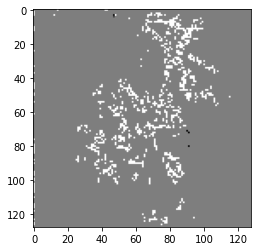

In [ ]:

#Test on a different image
#READ EXTERNAL IMAGE...
test_img = cv2.imread('/content/drive/MyDrive/007_image.png', cv2.IMREAD_COLOR)
test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
test_img = np.expand_dims(test_img, axis=0)

#predict_image = np.expand_dims(X_train[8,:,:,:], axis=0)
X_test_feature = new_model.predict(test_img)
X_test_feature = X_test_feature.reshape(-1, X_test_feature.shape[3])

prediction = loaded_model.predict(X_test_feature)

#View and Save segmented image
prediction_image = prediction.reshape(mask.shape)
plt.imshow(prediction_image, cmap='gray')
# plt.imsave('images/test_images/360_segmented.jpg', prediction_image, cmap='gray')


In [ ]:
np.shape(prediction_image)

(128, 128)